<a href="https://colab.research.google.com/github/okayteakay/Exoplanets-Detection/blob/main/Exoplanets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [125]:
import os
import warnings
import math
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from sklearn.metrics import mean_squared_error, mean_absolute_error
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split 
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score,roc_curve,auc, f1_score, roc_auc_score,confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, normalize
from scipy import ndimage
import seaborn as sns
from sklearn.decomposition import PCA

## Load & PreProcess Data

In [126]:
train_data = pd.read_csv('exoTrain.csv')
test_data = pd.read_csv('exoTest.csv')
print(train_data)
print(test_data)

      LABEL   FLUX.1   FLUX.2  ...  FLUX.3195  FLUX.3196  FLUX.3197
0         2    93.85    83.81  ...      61.42       5.08     -39.54
1         2   -38.88   -33.83  ...       6.46      16.00      19.93
2         2   532.64   535.92  ...     -28.91     -70.02     -96.67
3         2   326.52   347.39  ...     -17.31     -17.35      13.98
4         2 -1107.21 -1112.59  ...    -384.65    -411.79    -510.54
...     ...      ...      ...  ...        ...        ...        ...
5082      1   -91.91   -92.97  ...     -17.00       3.23      19.28
5083      1   989.75   891.01  ...     100.28     -45.64      35.58
5084      1   273.39   278.00  ...      88.42      79.07      79.43
5085      1     3.82     2.09  ...     -14.55      -6.41      -2.55
5086      1   323.28   306.36  ...     -16.72     -14.09      27.82

[5087 rows x 3198 columns]
     LABEL   FLUX.1   FLUX.2  ...  FLUX.3195  FLUX.3196  FLUX.3197
0        2   119.88   100.21  ...      35.78     269.43      57.72
1        2  5736.59  5

In [127]:
train_data.dtypes

LABEL          int64
FLUX.1       float64
FLUX.2       float64
FLUX.3       float64
FLUX.4       float64
              ...   
FLUX.3193    float64
FLUX.3194    float64
FLUX.3195    float64
FLUX.3196    float64
FLUX.3197    float64
Length: 3198, dtype: object

In [128]:
train_data["LABEL"].replace({1: 0, 2: 1}, inplace=True)
print(train_data)

      LABEL   FLUX.1   FLUX.2  ...  FLUX.3195  FLUX.3196  FLUX.3197
0         1    93.85    83.81  ...      61.42       5.08     -39.54
1         1   -38.88   -33.83  ...       6.46      16.00      19.93
2         1   532.64   535.92  ...     -28.91     -70.02     -96.67
3         1   326.52   347.39  ...     -17.31     -17.35      13.98
4         1 -1107.21 -1112.59  ...    -384.65    -411.79    -510.54
...     ...      ...      ...  ...        ...        ...        ...
5082      0   -91.91   -92.97  ...     -17.00       3.23      19.28
5083      0   989.75   891.01  ...     100.28     -45.64      35.58
5084      0   273.39   278.00  ...      88.42      79.07      79.43
5085      0     3.82     2.09  ...     -14.55      -6.41      -2.55
5086      0   323.28   306.36  ...     -16.72     -14.09      27.82

[5087 rows x 3198 columns]


In [129]:
test_data["LABEL"].replace({1: 0, 2: 1}, inplace=True)
print(test_data)


     LABEL   FLUX.1   FLUX.2  ...  FLUX.3195  FLUX.3196  FLUX.3197
0        1   119.88   100.21  ...      35.78     269.43      57.72
1        1  5736.59  5699.98  ...   -2366.19   -2294.86   -2034.72
2        1   844.48   817.49  ...    -162.68     -36.79      30.63
3        1  -826.00  -827.31  ...    -120.81    -257.56    -215.41
4        1   -39.57   -15.88  ...     -61.98     -69.34     -17.84
..     ...      ...      ...  ...        ...        ...        ...
565      0   374.46   326.06  ...    -213.63    -205.99    -194.07
566      0    -0.36     4.96  ...      -5.32     -10.98     -11.24
567      0   -54.01   -44.13  ...       5.47      14.46      18.70
568      0    91.36    85.60  ...      -8.43      -6.48      17.60
569      0  3071.19  2782.53  ...    -277.22     -69.63     121.56

[570 rows x 3198 columns]


#### Visualizing Class Imbalance

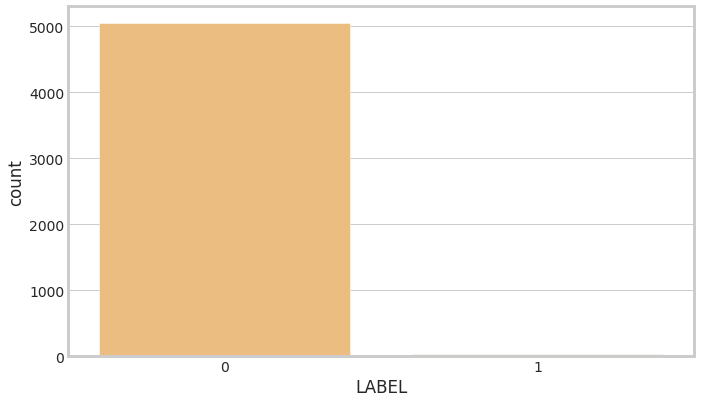

In [130]:
sns.set_style('whitegrid')
sns.countplot(x='LABEL',data=train_data,palette='Spectral')
plt.show()

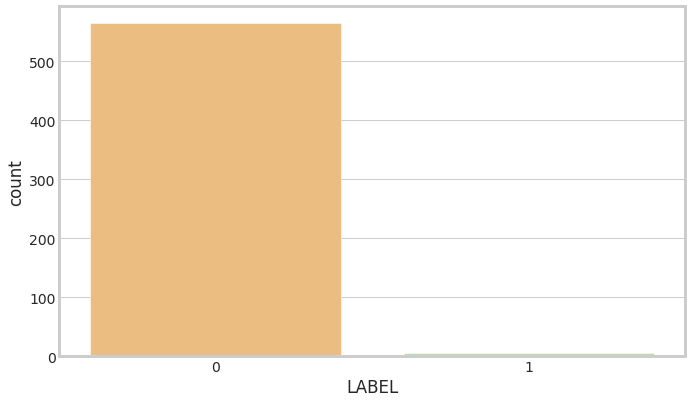

In [131]:
sns.set_style('whitegrid')
sns.countplot(x='LABEL',data=test_data,palette='Spectral')
plt.show()

#### Visualizing Distribution of Fluxes

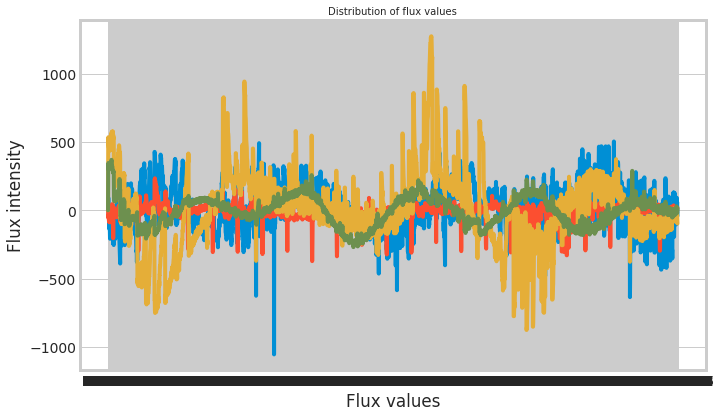

In [132]:
plt.title('Distribution of flux values', fontsize=10)
plt.xlabel('Flux values')
plt.ylabel('Flux intensity')
plt.plot(train_data.iloc[0,])
plt.plot(train_data.iloc[1,])
plt.plot(train_data.iloc[2,])
plt.plot(train_data.iloc[3,])
plt.show()

#### Splitting Training Data

In [133]:
X_train = train_data.drop(["LABEL"],axis=1)
y_train = train_data["LABEL"]   
X_test = test_data.drop(["LABEL"],axis=1)
y_test = test_data["LABEL"]

#### Oversampling to overcome Class Imbalance Problem by creating fake instances 

In [134]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))
sm = SMOTE(random_state=27, ratio = 1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 37
Before OverSampling, counts of label '0': 5050 

After OverSampling, counts of label '1': 5050
After OverSampling, counts of label '0': 5050


#### Optimising to reduce memory usage

In [135]:
def reduce_memory(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
            end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    dftest_data = reduce_memory(test_data)
    return (dftest_data)

#### Guassian Histogram

In [136]:
X_train_res = pd.DataFrame(X_train_res)

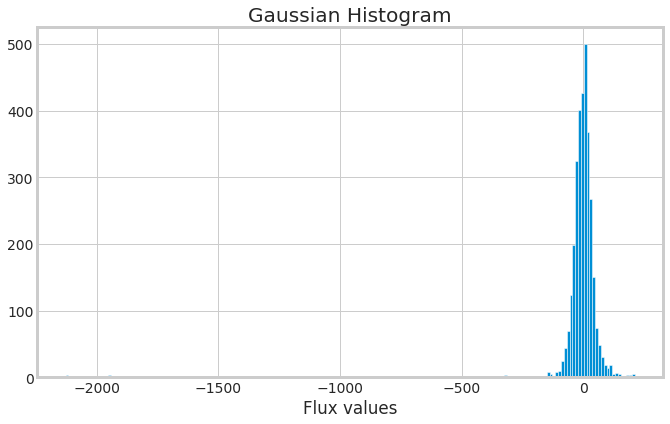

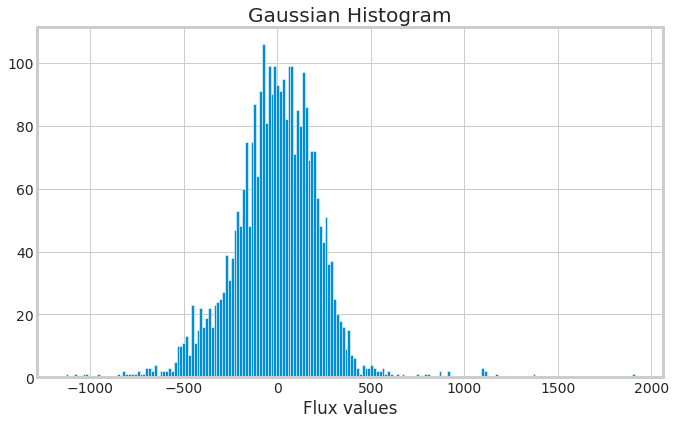

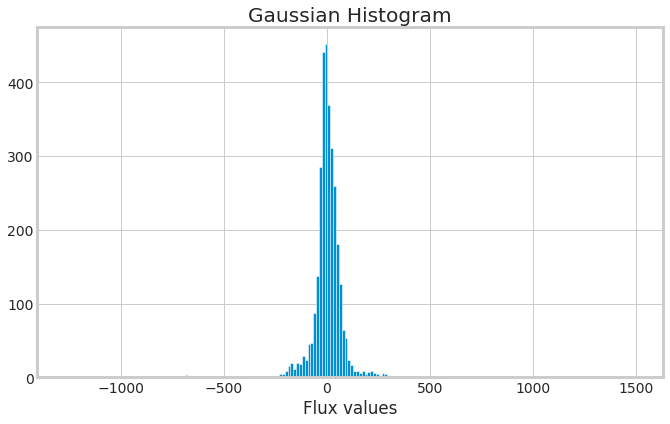

In [137]:
labels_1=[100,200,300]
for i in labels_1:
    plt.hist(X_train_res.iloc[i,:], bins=200)
    plt.title("Gaussian Histogram")
    plt.xlabel("Flux values")
    plt.show()

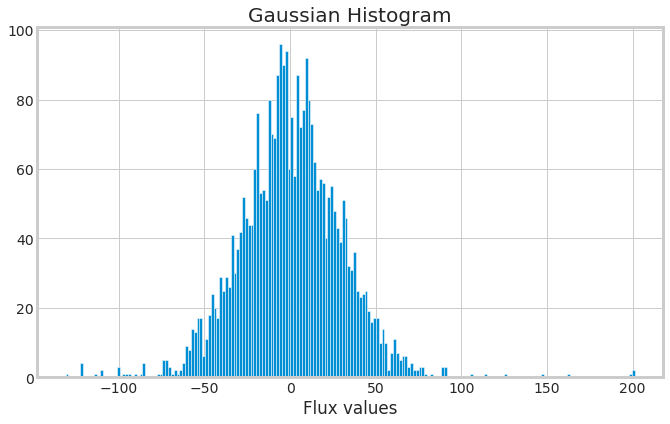

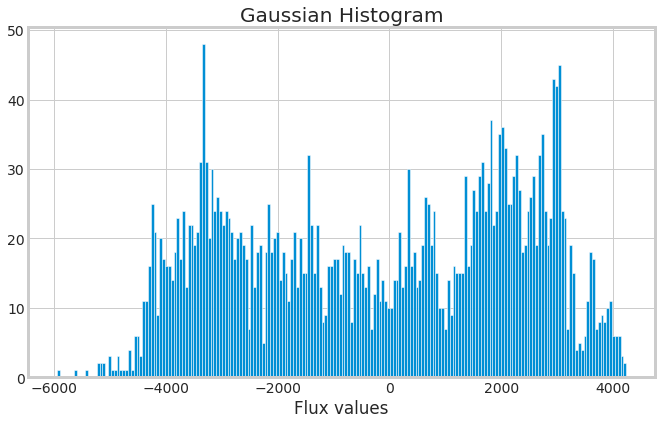

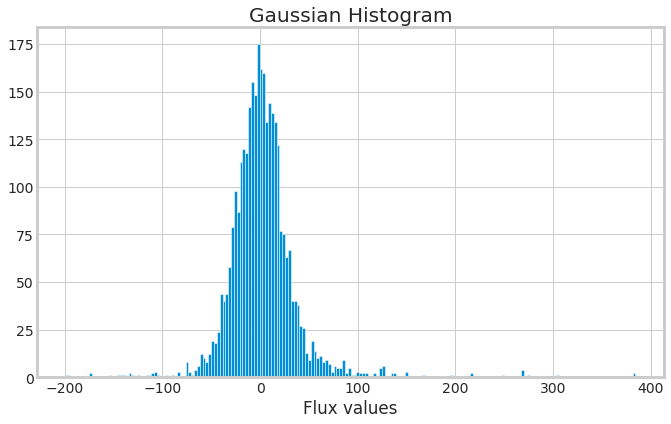

In [138]:
labels_1=[16,21,25]
for i in labels_1:
    plt.hist(X_train_res.iloc[i,:], bins=200)
    plt.title("Gaussian Histogram")
    plt.xlabel("Flux values")
    plt.show()

#### Filling NA Values

In [139]:
X_train_res.isna().sum()

0       0
1       0
2       0
3       0
4       0
       ..
3192    0
3193    0
3194    0
3195    0
3196    0
Length: 3197, dtype: int64

In [140]:
count = np.isinf(train_data).values.sum() 
print("It contains " + str(count) + " infinite values") 

It contains 0 infinite values


In [83]:
# list = []
# for i,cols in enumerate(train_data.columns):
#   me = np.mean(train_data[cols])
#   train_data[cols] = train_data.fillna(me)
#   # print(f'{i} out of {len(train_data.columns)} done') 

In [84]:
# train_data.isna().sum()

#### Normalizing 

In [87]:
X_train_res = normalize(X_train_res)

In [88]:
X_test = normalize(X_test)

In [89]:
X_train_res = ndimage.filters.gaussian_filter(X_train_res, sigma=10)
X_test = ndimage.filters.gaussian_filter(X_test, sigma=10)


In [90]:
std_scaler = StandardScaler()
X_train_res = scaled = std_scaler.fit_transform(X_train_res)
X_test = std_scaler.fit_transform(X_test)

In [91]:
np.mean(X_train_res),np.std(X_train_res)

(1.5276920778888993e-17, 0.9999999999999992)

In [92]:
print('X_train_res:', X_train_res.shape)
print('y_train_res:', y_train_res.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train_res: (10100, 3197)
y_train_res: (10100,)
X_test: (570, 3197)
y_test: (570,)


#### Dimensionality Reduction

In [102]:
#Dimentioanlity reduction
from sklearn.decomposition import PCA
pca = PCA() 
X_train_res = pca.fit_transform(X_train_res)
X_test = pca.transform(X_test)
total=sum(pca.explained_variance_)
k=0
current_variance=0
while current_variance/total < 0.9:
    current_variance += pca.explained_variance_[k]
    k=k+1

In [103]:
k

23

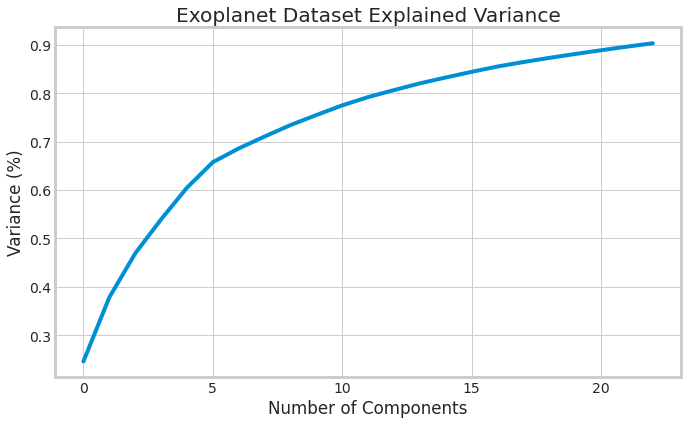

In [105]:
#Apply PCA with n_componenets
pca = PCA(n_components=k)
X_train_res = pca.fit_transform(X_train_res)
X_test = pca.transform(X_test)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Exoplanet Dataset Explained Variance')
plt.show()

## General Model Build

In [107]:
def model(classifier,X_train_res,y_train_res,X_test,y_test):
    #fit the model
    classifier.fit(X_train_res,y_train_res)
    predictions = classifier.predict(X_test)
    
    #Cross validation
    accuracies = cross_val_score(estimator = classifier, X = X_train_res, y = y_train_res, cv = 5, n_jobs = -1)
    mean = accuracies.mean()
    variance = accuracies.std()
    print("Accuracy mean: "+ str(mean))
    print("Accuracy variance: "+ str(variance))
    
    #Accuracy
    print ("\naccuracy_score :",accuracy_score(y_test,predictions))
    
    #Classification report
    print ("\nclassification report :\n",(classification_report(y_test,predictions)))
    
    #Confusion matrix
    plt.figure(figsize=(13,10))
    plt.subplot(221)
    sns.heatmap(confusion_matrix(y_test,predictions),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
    plt.title("CONFUSION MATRIX",fontsize=20)

#### SVM

Accuracy mean: 0.9945544554455445
Accuracy variance: 0.00615137606614221

accuracy_score : 0.8385964912280702

classification report :
               precision    recall  f1-score   support

           0       0.99      0.85      0.91       565
           1       0.00      0.00      0.00         5

    accuracy                           0.84       570
   macro avg       0.49      0.42      0.46       570
weighted avg       0.98      0.84      0.90       570



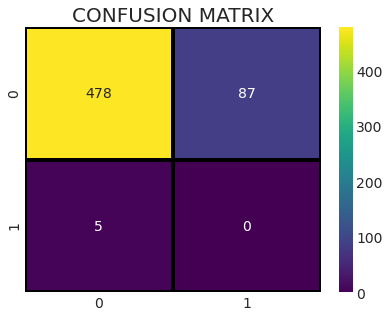

In [108]:
from sklearn.svm import SVC
SVM_model=SVC()
model(SVM_model,X_train_res,y_train_res,X_test,y_test)

#### Logistic Regression 

Accuracy mean: 0.9852475247524751
Accuracy variance: 0.009743298693182223

accuracy_score : 0.6157894736842106

classification report :
               precision    recall  f1-score   support

           0       1.00      0.61      0.76       565
           1       0.02      1.00      0.04         5

    accuracy                           0.62       570
   macro avg       0.51      0.81      0.40       570
weighted avg       0.99      0.62      0.75       570



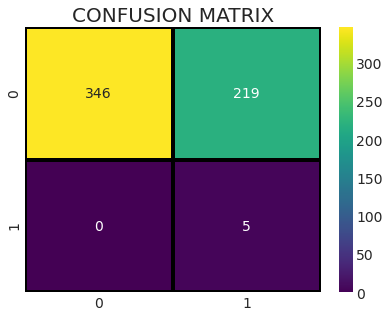

In [109]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression()
model(LR_model,X_train_res,y_train_res,X_test,y_test)

#### Random Forest

In [120]:
rf_scores = []
for r in range(1,24):
    randomforest_classifier= RandomForestClassifier(n_estimators=r)
    score=cross_val_score(randomforest_classifier,X_test,y_test)
    rf_scores.append(score.mean())

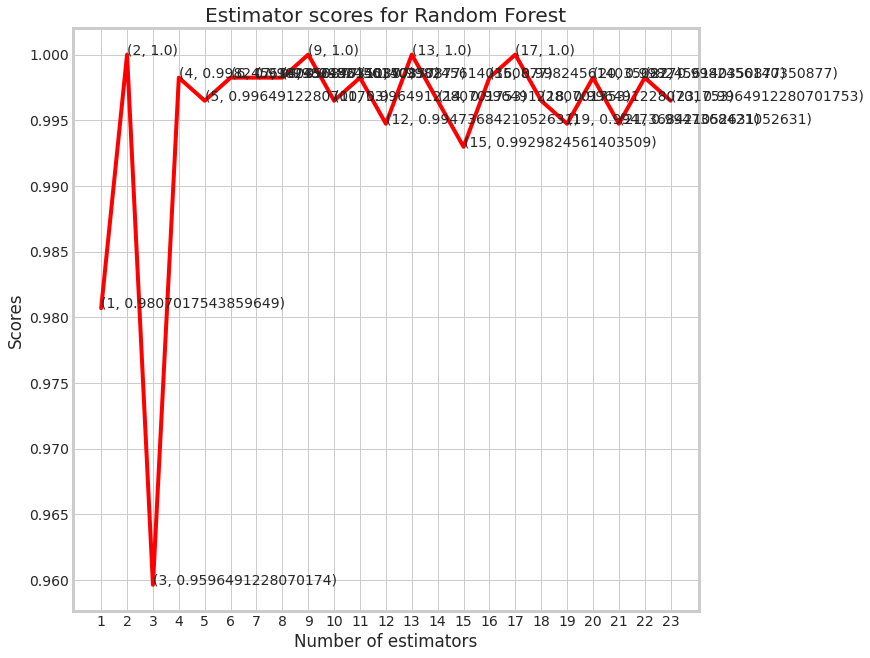

In [121]:
plt.figure(figsize=(10,10))
plt.plot([r for r in range(1, 24)], rf_scores, color = 'red')
for i in range(1,24):
    plt.text(i, rf_scores[i-1], (i, rf_scores[i-1]))
plt.xticks([i for i in range(1, 24)])
plt.xlabel('Number of estimators')
plt.ylabel('Scores')
plt.title('Estimator scores for Random Forest')
plt.show()

Accuracy mean: 0.9884158415841584
Accuracy variance: 0.012152835175531961

accuracy_score : 0.9701754385964912

classification report :
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       565
           1       0.00      0.00      0.00         5

    accuracy                           0.97       570
   macro avg       0.50      0.49      0.49       570
weighted avg       0.98      0.97      0.98       570



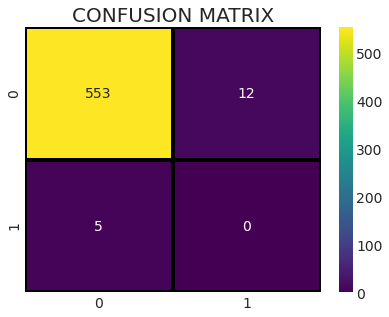

In [124]:
from sklearn.ensemble import RandomForestClassifier
randomforest_classifier= RandomForestClassifier(n_estimators=17)
model(randomforest_classifier,X_train_res,y_train_res,X_test,y_test)

#### KNN

In [112]:
from sklearn.neighbors import KNeighborsClassifier
knn_scores = []
for k in range(1,24):
    knn_classifier = KNeighborsClassifier(n_neighbors = k)
    score=cross_val_score(knn_classifier,X_train_res,y_train_res,cv=10)
    knn_scores.append(score.mean())

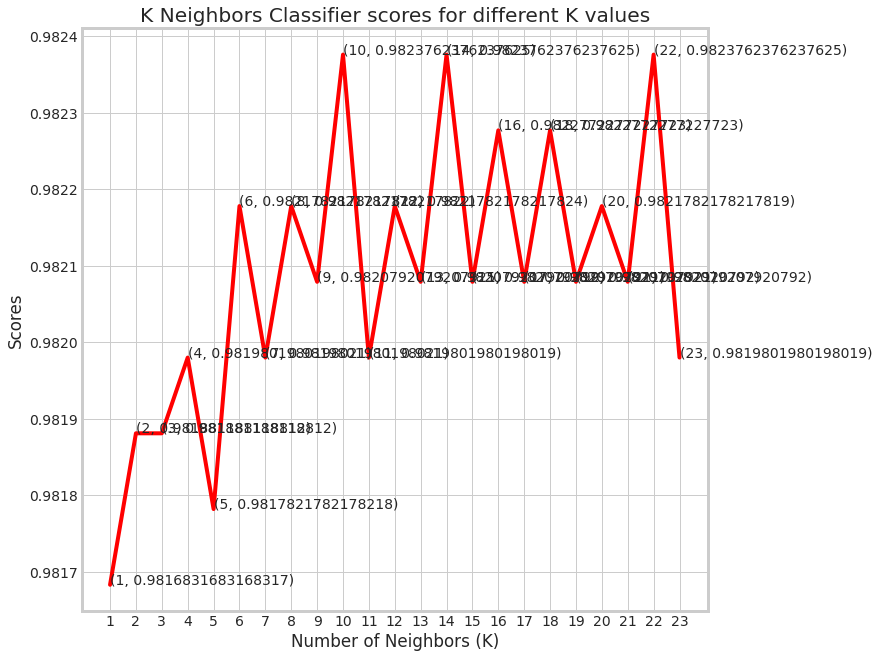

In [117]:
plt.figure(figsize=(10,10))
plt.plot([k for k in range(1, 24)], knn_scores, color = 'red')
for i in range(1,24):
    plt.text(i, knn_scores[i-1], (i, knn_scores[i-1]))
plt.xticks([i for i in range(1, 24)])
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Scores')
plt.title('K Neighbors Classifier scores for different K values')
plt.show()

Accuracy mean: 0.983069306930693
Accuracy variance: 0.006563094423436264

accuracy_score : 0.6491228070175439

classification report :
               precision    recall  f1-score   support

           0       0.99      0.65      0.79       565
           1       0.00      0.00      0.00         5

    accuracy                           0.65       570
   macro avg       0.49      0.33      0.39       570
weighted avg       0.98      0.65      0.78       570



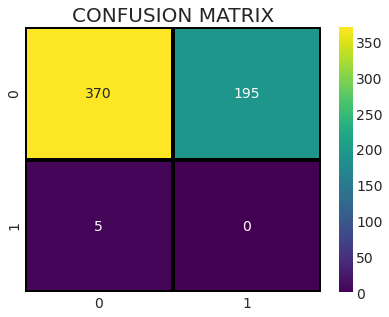

In [119]:
knn_classifier= KNeighborsClassifier(n_neighbors = 14)
model(knn_classifier,X_train_res,y_train_res,X_test,y_test)